In [66]:
import pandas as pd
import nltk
import matplotlib
import numpy as np

%matplotlib inline

In [99]:
df = pd.read_csv('./data/data.csv', 
                 encoding='ISO-8859-1',
                 dtype={'CustomerID':str},
                 parse_dates=['InvoiceDate'])

df.dropna(subset=['CustomerID'],inplace=True)
df.drop_duplicates(inplace=True)
df.shape

(401604, 8)

In [100]:
df_canceled = df.loc[df.Quantity<0,:]
df_norm = df.loc[df.Quantity>0,:]

display(df_canceled.head())
display(df_norm.head())
df_canceled.loc[df_canceled.StockCode.str.len()<5,'StockCode'].value_counts()
(df_canceled.Description!='Discount').sum()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


8795

In [124]:
merged = df_canceled.merge(how='right',right=df_norm,on=['CustomerID','StockCode'], suffixes=('_l',''))
df_2 = merged.loc[(merged.InvoiceDate_l>=merged.InvoiceDate) & (-merged.Quantity_l<=merged.Quantity),:]
df_2['size'] = df_2.groupby(['CustomerID','StockCode'])['Quantity'].transform(np.size)

/home/peter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [134]:

df_2['canceled'] = False
df_2.loc[df_2['size']==1,'canceled'] = True
keys = []
df_2.sort_values(by=['InvoiceDate_l'],inplace=True)
for group, cont in df_2.loc[df_2['size']>=2,:].groupby(by=['InvoiceNo_l','StockCode']):
    cont.sort_values(by=['InvoiceDate'], ascending=False, inplace=True)
    for ind,row in cont.iterrows():
        key = (row['InvoiceNo'],group[1])
        if key not in keys:
            keys.append(key)
            df_2.loc[(df_2.InvoiceNo_l==group[0])&
                     (df_2.StockCode == group[1])&
                     (df_2.InvoiceNo==row['InvoiceNo']),'canceled'] = True
            break

len(keys)

/home/peter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/peter/.local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/peter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2842

In [149]:
df_2.loc[(df_2.InvoiceNo_l=='C536826')&(df_2.StockCode=='35004B')&(df_2['canceled']==True),:].sort_values(by='InvoiceNo_l')

,InvoiceNo_l,StockCode,Description_l,Quantity_l,InvoiceDate_l,UnitPrice_l,CustomerID,Country_l,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,Country,size,canceled
241,C536826,35004B,SET OF 3 BLACK FLYING DUCKS,-3.0,2010-12-02 17:30:00,4.65,17924,United Kingdom,536397,SET OF 3 BLACK FLYING DUCKS,12,2010-12-01 10:51:00,4.65,United Kingdom,4,True
240,C536826,35004B,SET OF 3 BLACK FLYING DUCKS,-2.0,2010-12-02 17:30:00,4.65,17924,United Kingdom,536397,SET OF 3 BLACK FLYING DUCKS,12,2010-12-01 10:51:00,4.65,United Kingdom,4,True


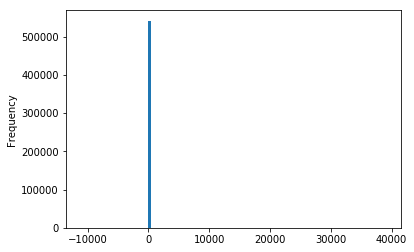

In [6]:
df.UnitPrice.plot(kind='hist',bins = 100)

In [8]:
df.loc[df.UnitPrice == df.UnitPrice.max(),:]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.0,15098,United Kingdom
